<a href="https://colab.research.google.com/github/kaburia/NOAA-workshop/blob/main/01_Ground_QC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focus Area 1 — Ground Observations Monitoring &amp; QC
**Core Objective**: To equip NMHS participants with tools for quality-controlling ground station
data and validating it against satellite products, enabling identification of network issues and
building confidence in observational networks.

In [1]:
!git clone https://github.com/kaburia/NOAA-workshop.git

Cloning into 'NOAA-workshop'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 119 (delta 57), reused 68 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 35.29 MiB | 12.81 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
!cd NOAA-workshop && pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.6/459.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
os.chdir("NOAA-workshop")

Required Dependencies

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel



import utils

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data, plot_xarray_data2
%matplotlib inline

## Data Extraction
- Accesssing TAHMO Data and CHIRPS Data

###  Extract TAHMO data using filter-stations

Documentation: https://filter-stations.netlify.app/

A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
}

```

In [ ]:
import json
from utils.filter_stations import RetrieveData

# Load the config file
with open('/content/config.json', 'r') as f:
    config = json.load(f)

# Set the api key and secret
api_key = config['apiKey']
api_secret = config['apiSecret']


# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)
api_key, api_secret

East Africa: April-May 2025 floods (Kenya/Rwanda/Uganda), where heavy rains overwhelmed stations.


In [ ]:
!pwd

In [ ]:
# get Kenyan TAHMO weather stations
ke_stations = rd.get_stations_info(countrycode='KE')
print(f"Number of stations in Kenya: {len(ke_stations)}")

# Rwandan Stations
rw_stations = rd.get_stations_info(countrycode='RW')
print(f"Number of stations in Rwanda: {len(rw_stations)}")

# Ugandan Stations
ug_stations = rd.get_stations_info(countrycode='UG')
print(f"Number of stations in Uganda: {len(ug_stations)}")

# Concatenate the East African stations
eac_stations = pd.concat([ke_stations, rw_stations, ug_stations])
print(f"Total number of stations in East Africa: {len(eac_stations)}")

In [ ]:
# Plot the stations on a map
plot_stations_folium([ke_stations, rw_stations, ug_stations],
                     colors=["blue", "red", "green"])

In [ ]:
# create the data directory/ground for the ground observations
os.makedirs("data/ground", exist_ok=True)

# save this data to be reused later
eac_stations.to_csv("data/ground/eac_stations.csv", index=False)

In [ ]:
# Extract the precipitation data for the East African stations (April -May 2025)
start_date = "2025-04-01"
end_date = "2025-05-31"

eac_precip = rd.multiple_measurements(stations_list=eac_stations['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['pr'],
                                     csv_file = "data/ground/eac_precip_apr_may_2025.csv")


### Extracting CHIRPS data

Extract the data from Google Earth engine project
Set up Google Earth Engine Project to access and extract the data


#### Steps to setting up Google Earth Engine Project

1. Get started from the link https://code.earthengine.google.com/register
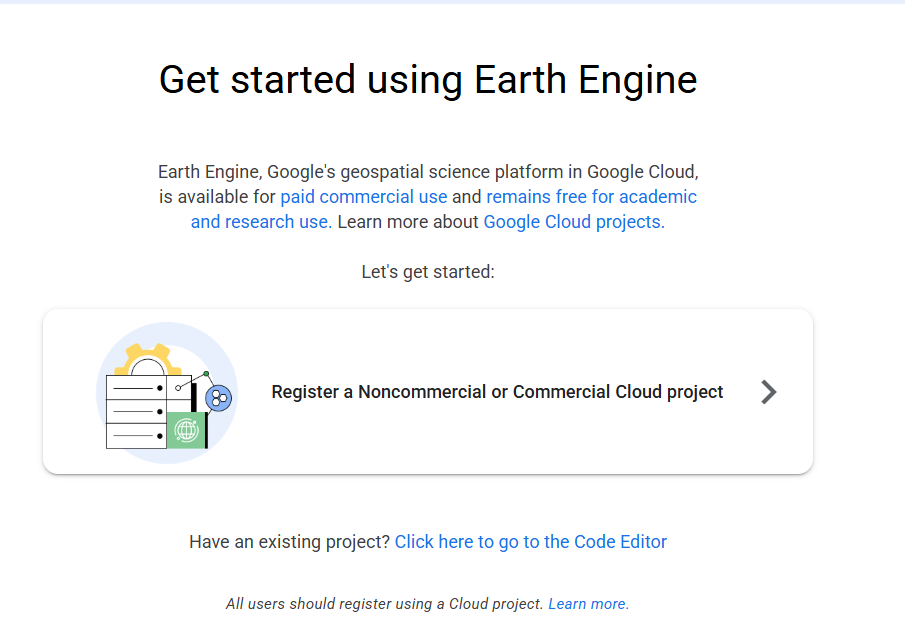

2. 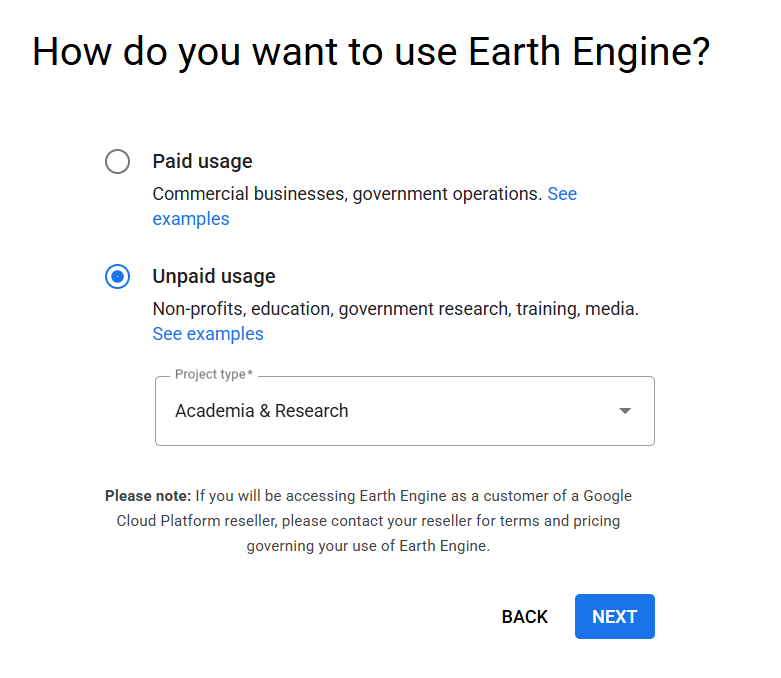

4. 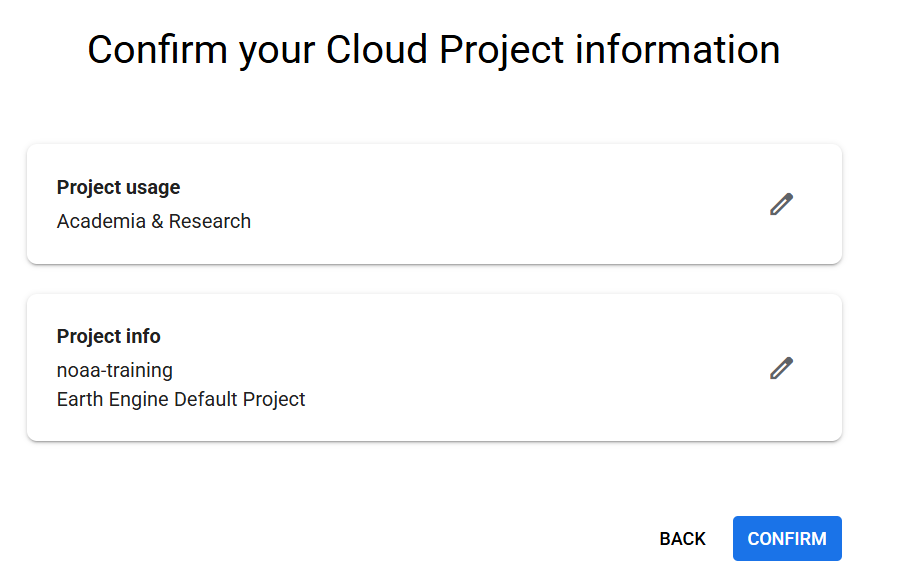

### Extracting CHIRPS Data for the Eat Africa Region (Kenya, Uganda, Rwanda)

Bounding box for the region =
```
[]
```

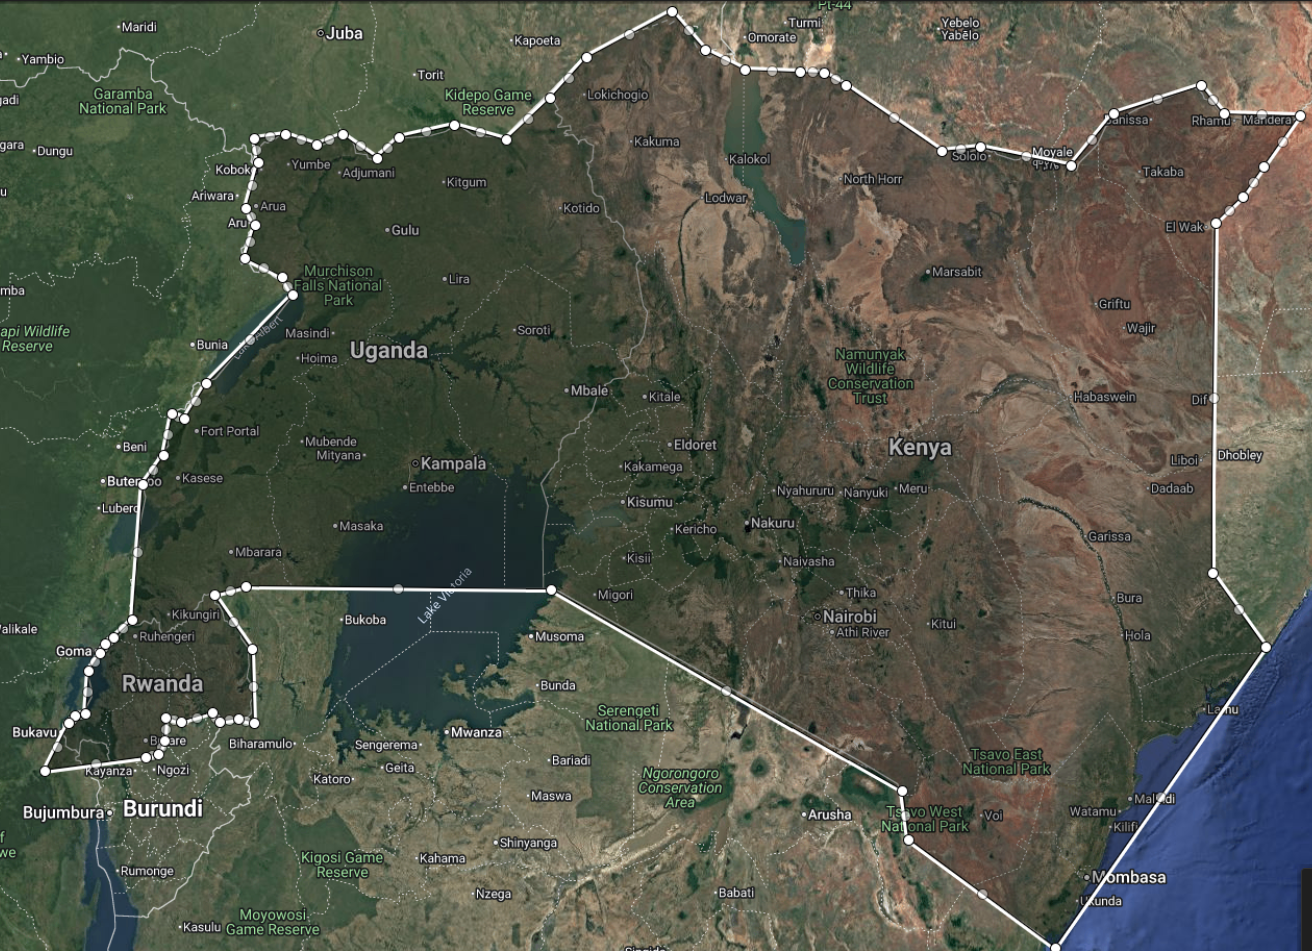

In [ ]:
# kenya_region = get_region_geojson('Kenya', config['location_keys'])['geometry']['coordinates'][0]
# uganda_region = get_region_geojson('Uganda', config['location_keys'])['geometry']['coordinates'][0]
# rwanda_region = get_region_geojson('Rwanda', config['location_keys'])['geometry']['coordinates'][0]

# EAC region to be the sum of this polygon
eac_region = eac_region = [[28.861754, -2.8399383],
 [28.861754, -2.8399383],
 [28.861754, -1.0473752],
 [29.573433, -1.4823178],
 [29.573433, -1.4823178],
 [29.573433, 4.218628],
 [30.8991179, -2.8399383],
 [30.8991179, -1.0473752],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, 5.033420899999999],
 [35.0330489, -1.4823178],
 [35.0330489, 4.218628],
 [41.9068688, -4.724299999999999],
 [41.9068688, 5.033420899999999]]
sorted(eac_region)

In [ ]:
def xmin_ymin_xmax_ymax(polygon):
    lons = [point[0] for point in polygon]
    lats = [point[1] for point in polygon]
    return min(lons), min(lats), max(lons), max(lats)
xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(eac_region)
print(xmin, ymin, xmax, ymax)

In [ ]:

ee.Authenticate()
ee.Initialize(project='leafy-computing-310902')

# Define region of interest (Kenya)
roi = ee.Geometry.Polygon(eac_region)

# Make directory to save satellite data
os.makedirs("data/satellite", exist_ok=True)

# Extract data for 2020
ds = get_chirps_pentad_gee(
    start_date="2025-04-01",
    end_date="2025-05-31",
    region=roi,
    export_path='data/satellite/chirps_pentad_eac.nc'
)

print(ds)

In [ ]:
ds

In [ ]:
ds = ds.where(ds != -9999)

In [ ]:
ds.precipitation.sel(x=41.5, y=-5.3, method="nearest").to_pandas()

In [ ]:
# Select a single time and the (only) band to obtain a 2D array (y, x) for plotting
# pentad_da = ds.band_data.isel(time=0, band=0).squeeze()

# Wrap back into a dataset so the plotting helper expecting a dataset+column works
# pentad_ds = pentad_da.to_dataset(name='band_data')

plot_xarray_data(
    ds,
    column='precipitation',
    fig_title='CHIRPS Pentad Precipitation (mm)\n(Pentad starting {})'.format(str(ds.time.values[0])[:10]),
    polygon=eac_region
)

In [ ]:
plot_xarray_data2(
    xarray_ds=ds,
    fig_title="CHIRPS Precipitation Analysis in East Africa",
    columns=["precipitation"],
    plot_size=7,
    bbox=[xmin, ymin, xmax, ymax],
)

## Data Processing
1. Range, missing, and flatline detection (≥ N days with unchanged values).
2. Aggregate station rain to pentads to match CHIRPS.
3. Nearest-pixel extraction from CHIRPS and merge with station pentads.
4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for
bias.
5. Combine into a 0–100 confidence score and classify (High/Medium/Low).

In [ ]:
# Load the CHIRPS and station data
import xarray as xr

eac_data = pd.read_csv("data/ground/eac_precip_apr_may_2025.csv.csv")
# eac metadata
eac_metadata = pd.read_csv("data/ground/eac_stations.csv")
eac_metadata = eac_metadata[['code', 'location.latitude', 'location.longitude']].rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

# CHIRPS Xarray dataset
chirps_ds = xr.open_dataset("data/satellite/chirps_pentad_eac.nc")

Format CHIRPS Data

In [ ]:
chirps_ds = chirps_ds.where(chirps_ds != -9999)
chirps_ds.precipitation.sel(x=41.5, y=-5.3, method="nearest").to_pandas()

Format the TAHMO Data

In [ ]:
# Rename Unnamed columns
eac_data = eac_data.rename(columns={"Unnamed: 0": "Date"})
# set Date as datetime
eac_data['Date'] = pd.to_datetime(eac_data['Date'])
# set as index
eac_data = eac_data.set_index('Date')
# localize to None
eac_data.index = eac_data.index.tz_localize(None)

### 1. Range, missing, and flatline detection (≥ N days with unchanged values).

In [ ]:
# Check the range of the data and plot any of the stations randomly
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

plot_stations_data_randomly(eac_data)

In [ ]:
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


In [ ]:
# drop stations with all missing data
eac_data = eac_data.dropna(how='all', axis=1)
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")

In [ ]:
# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in eac_data.columns if len(i.split('_')) > 1]
eac_data = eac_data.drop(columns=multiple_sensors)
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


In [ ]:
eac_data.TA00001.rolling(window=5).std()

In [ ]:
# Check for flatlines when values do not change for k days (k=5) with a rolling window
def detect_flatlines(data, window_size=5):
    # store the station and the window in a dictionary
    flatline_info = {}
    for station in data.columns:
        rolling_std = data[station].rolling(window=window_size).std()
        flatline_periods = rolling_std[rolling_std == 0].index.tolist()
        if flatline_periods:
            flatline_info[station] = flatline_periods
    return flatline_info
flatlines = detect_flatlines(eac_data, window_size=5)
print(f"Stations with flatlines: {flatlines}")

In [ ]:
# plot the flatline stations highlighting flatline periods in red
def plot_flatline_stations(data, flatline_info, window_size=5, random=True):
    import random

    if not flatline_info:
        print("No flatlines detected.")
        return

    station = random.choice(list(flatline_info.keys())) if random else list(flatline_info.keys())[0]
    station_data = data[station].copy()

    # Build a mask for flatline periods
    mask = pd.Series(False, index=station_data.index)
    periods = flatline_info[station]
    for end_ts in periods:
        if end_ts in station_data.index:
            # mark the window contributing to zero std
            start_pos = station_data.index.get_loc(end_ts) - window_size + 1
            if start_pos >= 0:
                flat_index = station_data.index[start_pos: station_data.index.get_loc(end_ts) + 1]
                mask.loc[flat_index] = True

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, color='steelblue', marker='o', label='Values')

    # Overlay flatline segments in red
    if mask.any():
        flat_series = station_data[mask]
        # To keep contiguous red segments joined, plot as line over masked points sorted
        plt.plot(flat_series.index, flat_series.values, color='red', linewidth=2.5, marker='o', label='Flatline')

    plt.title(f'Precipitation Data for Station {station} (Flatlines Highlighted)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Station Code: {station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")
    if periods:
        print(f"Flatline window end timestamps (window={window_size}):")
        for ts in periods:
            print(f"  - {ts}")
    else:
        print("No flatline periods for this station.")

plot_flatline_stations(eac_data, flatlines, window_size=5, random=True)

### 2. Aggregate station rain to pentads to match CHIRPS.

In [ ]:
eac_pentad = rd.aggregate_variables(eac_data, freq='5D', method='sum')[:-1]
eac_pentad

### 3. Nearest-pixel extraction from CHIRPS and merge with station pentads.

In [ ]:
# filter to the required stations
req_stations = eac_pentad.columns.tolist()

eac_metadata = eac_metadata[eac_metadata['code'].isin(req_stations)]

In [ ]:
# Build the dataset from the station coordinates by selecting
def build_chirps_from_stations(chirps_ds, stations_metadata):
    import xarray as xr
    import pandas as pd

    all_stations_data = {}
    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = row['lat']
        lon = row['lon']

        # Extract nearest pixel data
        station_da = chirps_ds.precipitation.sel(x=lon, y=lat, method="nearest")
        station_df = station_da.to_dataframe().rename(columns={'precipitation': station_code})

        all_stations_data[station_code] = station_df[station_code]

    # Combine all stations into a single DataFrame
    combined_df = pd.DataFrame(all_stations_data)
    return combined_df

In [ ]:
chirps_stations = build_chirps_from_stations(chirps_ds, eac_metadata)
chirps_stations

In [ ]:
# Plot the CHIRPS data and TAHMO equivalents for a random station
def plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations):
    import random
    station_codes = eac_pentad.columns.intersection(chirps_stations.columns).tolist()
    if not station_codes:
        print("No common stations between EAC pentad data and CHIRPS data.")
        return

    random_station = random.choice(station_codes)

    tahmo_data = eac_pentad[random_station]
    chirps_data = chirps_stations[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(tahmo_data.index, tahmo_data.values, marker='o', label='TAHMO', color='blue')
    plt.plot(chirps_data.index, chirps_data.values, marker='x', label='CHIRPS', color='orange')
    plt.title(f'Precipitation Comparison for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"TAHMO Data Range: {tahmo_data.min()} mm to {tahmo_data.max()} mm")
    print(f"CHIRPS Data Range: {chirps_data.min()} mm to {chirps_data.max()} mm")
    print(f"Number of TAHMO Records: {len(tahmo_data)}")
    print(f"Number of CHIRPS Records: {len(chirps_data)}")
plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations)

### 4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for bias.

In [ ]:
eac_pentad.columns == chirps_stations.columns

In [ ]:
# RMSE
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))

'''
1. Compute the RMSE
2. Compute the Pearson correlation coefficient
3. Compute the ttest for bias
    bias significance (p<0.05) ['Significant' if p_val < 0.05 else 'Not Significant']
4. Compute completeness (% of non-missing values)
        completeness = 1 - g['station_pentad'].isna().mean()
        outlier_rate = (g['station_pentad']<0).mean()
5. confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate))
'''

In [ ]:
# Suggest to the formla on calculating confidence scores to subtract rmse

In [ ]:
# compute station scores
def compute_station_scores(eac_pentad, chirps_stations): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    # get the union stations
    stations = eac_pentad.columns.intersection(chirps_stations.columns)
    scores = []
    for station in stations:
        obs = eac_pentad[station]
        sim = chirps_stations[station]

        # Compute metrics
        r, _ = pearsonr(obs, sim)
        error = rmse(obs, sim)
        t_stat, p_val = ttest_rel(obs, sim)
        bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
        completeness = 1 - obs.isna().mean()
        outlier_rate = (obs < 0).mean()
        confidence_score = 100 * (0.4 * completeness + 0.4 * np.nan_to_num(r, nan=0) + 0.2 * (1 - outlier_rate))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                'pearson_r': r,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

In [ ]:
station_scores = compute_station_scores(eac_pentad, chirps_stations)

In [ ]:
station_scores.sort_values(by='rmse', ascending=True).head(10)


In [ ]:
station_scores.sort_values(by='rmse', ascending=True).iloc[10:20]


In [ ]:
# to the confidence scores subtract the rmse
station_scores['adjusted_confidence_score'] = station_scores['confidence_score'] - station_scores['rmse']
station_scores.sort_values(by='adjusted_confidence_score', ascending=False).head(20)

In [ ]:
def plot_station_vs_chirps_and_confidence(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    figsize_scatter=(6,5),
    figsize_map=(6,5)
):
    """
    Create:
      1) Scatter of all paired station pentad vs CHIRPS pentad values.
      2) Map of station confidence classes (High/Medium/Low).
    Parameters
    ----------
    station_pentad_df : DataFrame
        Aggregated station pentad totals (index = datetime, columns = station_id).
    chirps_pentad_df : DataFrame
        CHIRPS pentad precipitation extracted at station locations
        (same index + overlapping columns).
    station_scores_df : DataFrame
        Output of compute_station_scores (needs columns: station_id, confidence_score).
    metadata_df : DataFrame
        Must contain columns: code, lat, lon.
    country_label : str
        Title label.
    high_thr : float
        Threshold (inclusive upper) for High classification.
    low_thr : float
        Threshold upper bound for Low. Medium is (low_thr, high_thr).
    min_pairs : int
        Minimum valid (non-nan) pairs required to include a station in scatter.
    """
    # -----------------------------
    # 1. Build long paired dataset
    # -----------------------------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    all_rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame(
            {
                'station_pentad': s_obs,
                'sat_pentad': s_sat
            }
        ).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            all_rows.append(pair)
    if not all_rows:
        print("No stations with sufficient paired data.")
        return
    m = pd.concat(all_rows, axis=0)

    # -----------------------------
    # 2. Classify confidence
    # -----------------------------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify)

    # -----------------------------
    # 3. Merge with metadata
    # -----------------------------
    meta = metadata_df.rename(columns={'code': 'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left')

    # -----------------------------
    # 4. Scatter: station vs CHIRPS
    # -----------------------------
    plt.figure(figsize=figsize_scatter)
    plt.scatter(m['station_pentad'], m['sat_pentad'], s=14, alpha=0.55, edgecolor='none')
    # 1:1 line
    lim_max = max(m['station_pentad'].max(), m['sat_pentad'].max())
    plt.plot([0, lim_max], [0, lim_max], 'k--', linewidth=1)
    plt.xlabel('Station Pentad (mm)')
    plt.ylabel('CHIRPS Pentad (mm)')
    plt.title(f"{country_label}: Station vs CHIRPS (Pentad)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 5. Confidence class map
    # -----------------------------
    plt.figure(figsize=figsize_map)
    for cls, color in zip(['High','Medium','Low'], ['green','orange','red']):
        sel = score_map[score_map['class'] == cls]
        if not sel.empty:
            plt.scatter(sel['lon'], sel['lat'], label=cls, s=32, c=color, alpha=0.8)
    plt.legend(title='Confidence')
    plt.title(f"{country_label} Station Confidence Classes")
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return m, score_map

# Example call (adjust variable names if needed)
# m_pairs, score_with_meta = plot_station_vs_chirps_and_confidence(
#     eac_pentad,           # station pentad dataframe
#     chirps_stations,      # CHIRPS-at-stations pentad dataframe
#     station_scores,       # scores dataframe
#     eac_metadata,         # metadata with code, lat, lon
#     country_label="EAC (Kenya/Uganda/Rwanda)"
# )

In [ ]:
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

def plot_station_vs_chirps_and_confidence_interactive(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    scatter_color="#3366cc"
):
    """
    Scatter: single color (no category legend)
    Geo map: always shows High / Medium / Low categories
    Returns:
      m_long, score_map, scatter_fig, map_fig
    """
    # -------- 1. Build long paired dataset --------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame({'station_pentad': s_obs, 'sat_pentad': s_sat}).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            rows.append(pair)
    if not rows:
        print("No stations with sufficient paired data.")
        return None, None, None, None
    m_long = pd.concat(rows, axis=0).reset_index(drop=True)

    # -------- 2. Always compute classification for map --------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify_fn(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify_fn)
    # enforce category ordering even if some missing
    cls_order = ['High','Medium','Low']
    sc['class'] = pd.Categorical(sc['class'], categories=cls_order, ordered=True)

    # -------- 3. Merge with metadata --------
    meta = metadata_df.rename(columns={'code':'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left').dropna(subset=['lat','lon'])
    score_map['class'] = pd.Categorical(score_map['class'], categories=cls_order, ordered=True)

    # -------- 4. Merge scores into long paired --------
    merge_cols = ['station_id','confidence_score','class','pearson_r','rmse','completeness','outlier_rate','bias_signif']
    existing = [c for c in merge_cols if c in sc.columns]
    m_long = m_long.merge(sc[existing], on='station_id', how='left')

    # -------- 5. Scatter (single color) --------
    lim_max = float(max(m_long['station_pentad'].max(), m_long['sat_pentad'].max()))
    hover_data = {
        'station_id': True,
        'time': True,
        'station_pentad': ':.2f',
        'sat_pentad': ':.2f',
        'confidence_score': ':.1f',
        'class': True,
        'pearson_r': ':.3f',
        'rmse': ':.2f',
        'completeness': ':.2f',
        'outlier_rate': ':.3f',
        'bias_signif': True
    }
    scatter_fig = px.scatter(
        m_long,
        x='station_pentad',
        y='sat_pentad',
        title=f"{country_label}: Station vs CHIRPS (Pentad)",
        hover_data=hover_data,
        labels={'station_pentad':'Station (mm)','sat_pentad':'CHIRPS (mm)'}
    )
    scatter_fig.update_traces(marker=dict(color=scatter_color))
    scatter_fig.update_layout(showlegend=False)
    scatter_fig.add_trace(
        go.Scatter(
            x=[0, lim_max],
            y=[0, lim_max],
            mode='lines',
            line=dict(dash='dash', color='black'),
            name='1:1'
        )
    )
    scatter_fig.update_xaxes(constrain='domain')
    scatter_fig.update_yaxes(scaleanchor=None)

    # -------- 6. Geo Map (with categories) --------
    palette = {'High':'green','Medium':'orange','Low':'red'}
    map_fig = px.scatter_geo(
        score_map,
        lat='lat',
        lon='lon',
        color='class',
        color_discrete_map=palette,
        hover_name='station_id',
        hover_data={
            'confidence_score': ':.1f',
            'pearson_r': ':.3f',
            'rmse': ':.2f',
            'completeness': ':.2f',
            'outlier_rate': ':.3f',
            'bias_signif': True,
            'lat': ':.3f',
            'lon': ':.3f'
        },
        title=f"{country_label} Station Confidence"
    )
    map_fig.update_layout(legend_title_text='Confidence')

    if {'lat','lon'}.issubset(score_map.columns) and len(score_map):
        lat_min, lat_max = score_map['lat'].min(), score_map['lat'].max()
        lon_min, lon_max = score_map['lon'].min(), score_map['lon'].max()
        pad_lat = (lat_max - lat_min) * 0.1 if lat_max > lat_min else 1
        pad_lon = (lon_max - lon_min) * 0.1 if lon_max > lon_min else 1
        map_fig.update_geos(
            fitbounds="locations",
            lataxis_range=[lat_min - pad_lat, lat_max + pad_lat],
            lonaxis_range=[lon_min - pad_lon, lon_max + pad_lon],
            showland=True, landcolor="#EEEEEE",
            showcountries=True
        )

    return m_long, score_map, scatter_fig, map_fig

# Example call: scatter single color, map categorized
m_pairs, score_with_meta, scatter_fig, map_fig = plot_station_vs_chirps_and_confidence_interactive(
    eac_pentad,
    chirps_stations,
    station_scores,
    eac_metadata,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    scatter_color="#3366cc"
)

if scatter_fig is not None:
    scatter_fig.show()
    map_fig.show()


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go

# --- Flatline detection (unchanged) ---
def detect_flatlines_window(data, window_size=5):
    flatline_info = {}
    for station in data.columns:
        rolling_std = data[station].rolling(window=window_size).std()
        ends = rolling_std[rolling_std == 0].index.tolist()
        if ends:
            flatline_info[station] = ends
    return flatline_info

def _flat_segments(series, ends, window_size):
    if not ends:
        return []
    mask = pd.Series(False, index=series.index)
    for end in ends:
        start = end - pd.Timedelta(days=window_size - 1)
        span = (series.index >= start) & (series.index <= end)
        mask |= span
    flat_idx = series.index[mask]
    if len(flat_idx) == 0:
        return []
    groups = (flat_idx.to_series().diff() > pd.Timedelta(days=1)).cumsum()
    segs = [seg for _, seg in flat_idx.to_series().groupby(groups)]
    return segs

def plot_station_flatlines(data, station, flatline_info, window_size):
    series = data[station].copy()
    fig = go.Figure()
    fig.add_scatter(
        x=series.index, y=series.values,
        mode="lines+markers",
        name="Values",
        line=dict(color="#888", width=1),
        marker=dict(size=6, color="#555"),
        hovertemplate="Date=%{x|%Y-%m-%d}<br>Value=%{y:.2f}<extra></extra>"
    )
    if station in flatline_info:
        segs = _flat_segments(series, flatline_info[station], window_size)
        for i, seg in enumerate(segs):
            fig.add_scatter(
                x=seg,
                y=series.loc[seg],
                mode="lines+markers",
                name="Flatline",
                line=dict(color="red", width=4),
                marker=dict(size=7, color="white", line=dict(color="red", width=2)),
                hovertemplate="Date=%{x|%Y-%m-%d}<br>Flat Value=%{y:.2f}<extra></extra>",
                showlegend=(i == 0)
            )
    miss_prop = series.isna().mean()
    missing = series.isna().sum()
    total = len(series)
    flat_ct = len(flatline_info.get(station, []))
    fig.update_layout(
        title=f"Station {station} (Flatline window={window_size}d)",
        xaxis_title="Date",
        yaxis_title="Precipitation (mm)",
        height=360,
        legend=dict(orientation="h", y=1.02),
        margin=dict(l=40, r=10, t=60, b=40)
    )
    fig.add_annotation(
        text=f"Missing: {missing}/{total} ({miss_prop:.1%}) | Flat windows ends: {flat_ct}",
        xref="paper", yref="paper", x=0, y=1.10, showarrow=False, font=dict(size=11)
    )
    return fig

def plot_station_sat_timeseries(m_pairs, station):
    df = m_pairs[m_pairs.station_id == station].sort_values('time')
    if df.empty:
        return go.Figure().add_annotation(text="No pentad match data.", x=0.5, y=0.5, showarrow=False)
    fig = go.Figure()
    fig.add_scatter(
        x=df.time, y=df.station_pentad,
        mode="lines+markers",
        name="Station pentad",
        line=dict(color="#1f77b4"),
        marker=dict(size=6),
        hovertemplate="Pentad=%{x|%Y-%m-%d}<br>Station=%{y:.2f}<extra></extra>"
    )
    fig.add_scatter(
        x=df.time, y=df.sat_pentad,
        mode="lines+markers",
        name="CHIRPS pentad",
        line=dict(color="#ff7f0e"),
        marker=dict(size=6),
        hovertemplate="Pentad=%{x|%Y-%m-%d}<br>CHIRPS=%{y:.2f}<extra></extra>"
    )
    fig.update_layout(
        title=f"Pentad Comparison {station}",
        xaxis_title="Pentad start",
        yaxis_title="Precip (mm)",
        height=360,
        legend=dict(orientation="h", y=1.02),
        margin=dict(l=40, r=10, t=60, b=40)
    )
    return fig

# --- Helper to build adjusted score map ---
def build_adjusted_map(df, low, high):
    df = df.copy()
    def classify(v):
        if v >= high: return "High"
        if v >= low: return "Medium"
        return "Low"
    df["adjusted_class_new"] = df["adjusted_confidence_score"].apply(classify)
    colors = {"High": "green", "Medium": "orange", "Low": "red"}
    fig = go.Figure()
    for cls in ["High", "Medium", "Low"]:
        sub = df[df.adjusted_class_new == cls]
        if sub.empty:
            continue
        fig.add_scattergeo(
            lon=sub.lon,
            lat=sub.lat,
            text=sub.station_id,
            hovertext=sub.station_id,
            customdata=sub[["adjusted_confidence_score","confidence_score","pearson_r","rmse","completeness","outlier_rate"]],
            hovertemplate=(
                "<b>%{hovertext}</b><br>"
                "Adj score=%{customdata[0]:.1f}<br>"
                "Orig score=%{customdata[1]:.1f}<br>"
                "r=%{customdata[2]:.2f}<br>"
                "RMSE=%{customdata[3]:.1f}<br>"
                "Compl=%{customdata[4]:.2f}<br>"
                "Outliers=%{customdata[5]:.2f}<extra></extra>"
            ),
            mode="markers",
            marker=dict(color=colors[cls], symbol="circle", size=8),
            name=cls
        )
    fig.update_layout(
        title=f"Adjusted Confidence (Low={low}, High={high})",
        geo=dict(showland=True, landcolor="#EEEEEE", showcountries=True, fitbounds="locations"),
        legend_title="Adjusted Class",
        height=420,
        margin=dict(l=20,r=10,t=50,b=10)
    )
    return fig

# --- Shared controls (classification thresholds) on Page 1 ---
low_slider = widgets.IntSlider(value=low_slider.value if 'low_slider' in globals() else 40,
                               min=0, max=90, step=5, description='Low thr', continuous_update=False)
high_slider = widgets.IntSlider(value=high_slider.value if 'high_slider' in globals() else 70,
                                min=10, max=100, step=5, description='High thr', continuous_update=False)
show_adjusted_map_chk = widgets.Checkbox(description="Show adjusted score map", value=False)

# --- Page 1 widgets (overview) ---
refresh_overview_btn = widgets.Button(description='Update Overview', button_style='primary', icon='refresh')
output_overview = widgets.Output()
output_map = widgets.Output()
output_map_adjusted = widgets.Output()
output_scatter = widgets.Output()
output_sample_scores = widgets.Output()

# --- Page 2 widgets (station detail) ---
station_dropdown = widgets.Dropdown(options=sorted(eac_data.columns), description='Station', layout=widgets.Layout(width='240px'))
window_slider = widgets.IntSlider(value=5, min=3, max=20, step=1, description='Flat win', continuous_update=False)
missing_warn_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Max miss%', readout_format='.0%', continuous_update=False)
refresh_station_btn = widgets.Button(description='Update Station', icon='refresh')
output_station = widgets.Output()
output_station_comp = widgets.Output()

_current_flatlines_cache = {}

def refresh_overview(_=None):
    low = low_slider.value
    high = high_slider.value
    if low >= high:
        low_slider.value = max(0, high - 10)
        low = low_slider.value
    sc = station_scores.copy()

    # New classification on original confidence_score
    def classify(v):
        if v >= high: return 'High'
        if v >= low:  return 'Medium'
        return 'Low'
    sc['class_new'] = sc['confidence_score'].apply(classify)

    with output_overview:
        clear_output(wait=True)
        print("Reclassification counts:")
        display(sc['class_new'].value_counts())

    # Original map & scatter via existing function
    with output_map:
        clear_output(wait=True)
        try:
            _, score_map_new, scatter_fig_new, map_fig_new = plot_station_vs_chirps_and_confidence_interactive(
                eac_pentad,
                chirps_stations,
                station_scores,
                eac_metadata,
                country_label="EAC (Kenya/Uganda/Rwanda)",
                high_thr=high_slider.value,
                low_thr=low_slider.value,
                scatter_color="#3366cc"
            )
            if map_fig_new:
                display(map_fig_new)
        except Exception as exc:
            print("Map generation failed:", exc)
            scatter_fig_new = None

    # Adjusted map (conditional)
    with output_map_adjusted:
        clear_output(wait=True)
        if show_adjusted_map_chk.value:
            try:
                fig_adj = build_adjusted_map(score_with_meta, low, high)
                display(fig_adj)
            except Exception as exc:
                print("Adjusted map failed:", exc)

    # Scatter
    with output_scatter:
        clear_output(wait=True)
        if scatter_fig_new:
            display(scatter_fig_new)

    # Table (fix: no duplicate merge)
    with output_sample_scores:
        clear_output(wait=True)
        try:
            cols = ['station_id','confidence_score','pearson_r','rmse','completeness','outlier_rate','class','class_new']
            # Ensure columns exist
            present = [c for c in cols if c in sc.columns]
            print("Score table (first 15):")
            display(sc[present].head(15))
        except Exception as exc:
            print("Table failed:", exc)

def refresh_station(_=None):
    st = station_dropdown.value
    w = window_slider.value
    low = low_slider.value
    high = high_slider.value
    if low >= high:
        high_slider.value = min(100, low + 10)
    key = f"w{w}"
    if key not in _current_flatlines_cache:
        _current_flatlines_cache[key] = detect_flatlines_window(eac_data, window_size=w)
    flats = _current_flatlines_cache[key]
    with output_station:
        clear_output(wait=True)
        try:
            fig = plot_station_flatlines(eac_data, st, flats, w)
            display(fig)
            miss_prop = eac_data[st].isna().mean()
            if miss_prop > missing_warn_slider.value:
                print(f"WARNING: Missing proportion {miss_prop:.1%} exceeds {missing_warn_slider.value:.0%}")
        except Exception as exc:
            print("Flatline plot failed:", exc)
    with output_station_comp:
        clear_output(wait=True)
        try:
            fig2 = plot_station_sat_timeseries(m_pairs, st)
            display(fig2)
        except Exception as exc:
            print("Comparison plot failed:", exc)

# Events
refresh_overview_btn.on_click(refresh_overview)
show_adjusted_map_chk.observe(refresh_overview, names='value')
refresh_station_btn.on_click(refresh_station)
station_dropdown.observe(refresh_station, names='value')
window_slider.observe(refresh_station, names='value')

# --- Layout Page 1 (Map -> Optional Adjusted Map -> Scatter -> Table) ---
page1_controls = widgets.HBox([low_slider, high_slider, show_adjusted_map_chk, refresh_overview_btn])
page1_box = widgets.VBox([
    widgets.HTML("<b>Overview: Scatter & Map</b>"),
    page1_controls,
    output_map,
    output_map_adjusted,
    output_scatter,
    output_sample_scores
])

# --- Layout Page 2 ---
page2_controls = widgets.HBox([station_dropdown, window_slider, missing_warn_slider, refresh_station_btn])
page2_box = widgets.VBox([
    widgets.HTML("<b>Station Detail: Flatlines & CHIRPS Comparison</b>"),
    page2_controls,
    output_station,
    widgets.HTML("<b>Pentad Station vs CHIRPS</b>"),
    output_station_comp
])

tabs = widgets.Tab(children=[page1_box, page2_box])
tabs.set_title(0, "Overview")
tabs.set_title(1, "Station Detail")
display(tabs)

# Initial draws
refresh_overview()
refresh_station()
